In [26]:
import streamlit as st

from IPython.display import Image, display
from langchain import hub
from langchain.tools.retriever import create_retriever_tool
from langchain_pinecone import PineconeVectorStore
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, ToolMessage, RemoveMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from pinecone import Pinecone
from pydantic import BaseModel, Field
from typing import Literal, Annotated, Sequence
from typing_extensions import TypedDict

In [37]:
model_id = "gpt-4o-mini"
llm = ChatOpenAI(temperature=0.4, streaming=True, model=model_id)

## State

Define state

In [38]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: BaseMessage

## Retriever
Initialize the retriever

In [39]:
pc = Pinecone()
index = pc.Index("my-rag")
vectorstore = PineconeVectorStore(index=index, embedding=OpenAIEmbeddings())
retriever = vectorstore.as_retriever(k=2)
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ignacio_information",
    "Search and return information about Ignacio"
)
tools = [retriever_tool]

## Nodes

In [40]:
def filter(state):
    """
    Filter the messages deleting tool calls and documents retrieved.

    Args:
        state (messages): The current state
    
    Returns:
        dict: The updated state
    """
    print("===Filter===")
    remove_ids = [m.id for m in state["messages"] if isinstance(m, ToolMessage) or not m.content]
    delete_messages = [RemoveMessage(id=id) for id in remove_ids]
    return {"messages": delete_messages}

In [41]:
def contextualize_question(state):
    """
    Give context to the question for a better understanding

    Args:
        state (messages): The current state

    Returns:
        dict: The contextualized question
    """
    print("===Contextualize===")
    prompt = (
        "Given the above conversation, reformulate the last question for a "
        "better understanding without the context if possible. Otherwise, "
        "just paraphrase the last user input:"
    )
    messages = state["messages"] + [HumanMessage(content=prompt)]

    contextualized_question = llm.invoke(messages)
    print(contextualized_question)

    return {
        "question": contextualized_question
    }

In [43]:

def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("===Agent===")
    system = SystemMessage(content="You are Ignacio's assistant. You only answer question about him.")
    question = state["question"]
    messages = state["messages"]

    feed_messages = [system] + messages[:-1] + [question]

    model = ChatOpenAI(temperature=0.4, streaming=True, model=model_id)
    model = model.bind_tools(tools)
    response = model.invoke(feed_messages)
    # We return a list, because this will get added to the existing list
    return {
        "messages": [response],
    }

In [44]:
def generate(state):
    """
    Generate answer with the documents context.

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with the response
    """
    print("===Generate===")
    messages = state["messages"]
    question = state["question"]
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Chain
    rag_chain = prompt | llm

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}



## Graph

Build the graph

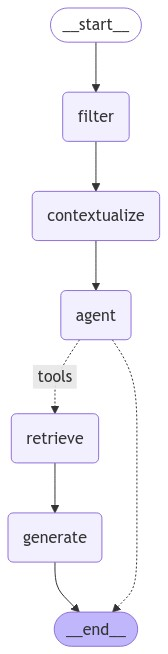

In [45]:
workflow = StateGraph(AgentState)
# Define nodes
workflow.add_node("filter", filter)
workflow.add_node("contextualize", contextualize_question)
workflow.add_node("agent", agent)
workflow.add_node("retrieve", ToolNode(tools))
workflow.add_node("generate", generate)
# Define edges
workflow.add_edge(START, "filter")
workflow.add_edge("filter", "contextualize")
workflow.add_edge("contextualize", "agent")
workflow.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END
    }
)
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)
# Add memory
memory = MemorySaver()
# Generate graph
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Tell me about Ignacio's experience")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="Oh! That is great")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

===Filter===
===Contextualize===
content="Hello! I'm Lance." additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f'} id='run-b05d91db-c5e2-4529-a767-2d772759bbfc-0'
===Agent===
================================== Ai Message ==================================

I'm here to assist you with any questions you have about Ignacio. What would you like to know?
===Filter===
===Contextualize===
content="Could you provide details about Ignacio's background or qualifications?" additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f'} id='run-56a6f19d-397b-40f0-9ca8-0d34758c6f30-0'
===Agent===
===Generate===
================================== Ai Message ==================================

Ignacio Sánchez Herrera holds an M.S. in Data Science from the University of Granada, specializing in NLP and machine learning, and has a B.S.

In [51]:

input_message = HumanMessage(content="Thank you!")
output = graph.invoke({"messages": [input_message]}, config=config) 
for m in output['messages'][-1:]:
    m.pretty_print()

===Filter===
===Contextualize===
content='Thank you for the information!' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f59a81427f'} id='run-44434639-cc16-4f5c-ab01-914ceb8239d5-0'
===Agent===
================================== Ai Message ==================================

You're welcome! If you have any more questions about Ignacio, feel free to ask!
